# Plot Compound Years for CESM

This file grabs the warm season indeces and sees if this shows us anything


You need to run cesmIndeces.ipnyb first

In [1]:
#For plots of a single experiment to demonstrate things, plot this one:

expToPlot = 'LME.002'

In [2]:
#import my functions
import sys
sys.path.append('../')

#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
from utils.timePeriod import averageForTimePeriod

%run "utils/compound.ipynb"

In [3]:
import xarray
import matplotlib.pyplot as plt
import numpy
import pandas
import scipy.stats

%matplotlib inline

In [4]:
firePos=xarray.open_dataset('results/cesmFirePos.nc')

fireNeg=xarray.open_dataset('results/cesmFireNeg.nc')

# In non-overlapping 30 year bins

Calculate non-overlapping 30 year bins, and sum the number of events in them

In [5]:
yearBins=numpy.arange(860, 2100, 30)

binMid=numpy.arange(875, 2086, 30)

#binnedFirePos=firePos.groupby_bins('year', yearBins, labels=binMid).sum() #This line is a bit problematic. If you have all nans in the bin, it will give you a sum of 0. It is probably more useful to return a nan

#Do the sum for each interval, but only it there are no Nans.
binnedFirePos=firePos.groupby_bins('year', yearBins, labels=binMid).map(
    lambda ds : ds.sum(dim='year').where(ds.isnull().any(dim='year')!=True)
)
binnedFirePos=binnedFirePos.rename({'year_bins':'year'})


In [6]:
binnedFirePos.sel(experiment='LME.002')

<xarray.Dataset>
Dimensions:     (year: 41)
Coordinates:
  * year        (year) int64 875 905 935 965 995 ... 1955 1985 2015 2045 2075
    experiment  <U7 'LME.002'
Data variables:
    dmi         (year) float64 9.0 4.0 7.0 7.0 8.0 6.0 ... 4.0 7.0 8.0 6.0 12.0
    nino34      (year) float64 5.0 3.0 5.0 4.0 6.0 2.0 ... 7.0 5.0 5.0 7.0 7.0
    sam         (year) float64 12.0 9.0 5.0 12.0 6.0 6.0 ... 7.0 0.0 1.0 1.0 0.0
    nEvents     (year) float64 26.0 16.0 17.0 23.0 20.0 ... 12.0 14.0 14.0 19.0
    all3        (year) float64 5.0 2.0 1.0 1.0 1.0 0.0 ... 1.0 0.0 0.0 0.0 0.0
    nino34+dmi  (year) float64 0.0 0.0 4.0 2.0 3.0 0.0 ... 3.0 4.0 5.0 4.0 7.0
    nino34+sam  (year) float64 0.0 1.0 0.0 1.0 0.0 1.0 ... 1.0 0.0 0.0 0.0 0.0
    dmi+sam     (year) float64 1.0 1.0 0.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0

Plot the mean in each bin for the full forcing ensemble and the rcp85 extensions

In [28]:
pairs=firePos.attrs['pairs']
toPlot=[*pairs,'all3']
colors=['orange', 'purple', 'green','blue']

def binPlot(da, expSet):

    plt.figure(figsize=(18,6))

    for counter in [0,1,2,3]:
        plt.vlines(
            x=da.year-3+1.5*counter, 
            ymin=0,
            ymax=da[toPlot[counter]].sel(experiment=expSet).mean(dim='experiment'),
            label=toPlot[counter],
            color=colors[counter]
        )

    plt.legend(loc='upper left')
    plt.xticks(ticks=da.year)
    plt.xlim(1700,2100)
    plt.xlabel('Mid-point of 30 year bin')
    plt.ylim(0,8)
    plt.ylabel('Number of events (mean)')
    plt.title('Pairs and all-three for runs with ' + str(expSet))
    plt.minorticks_on()

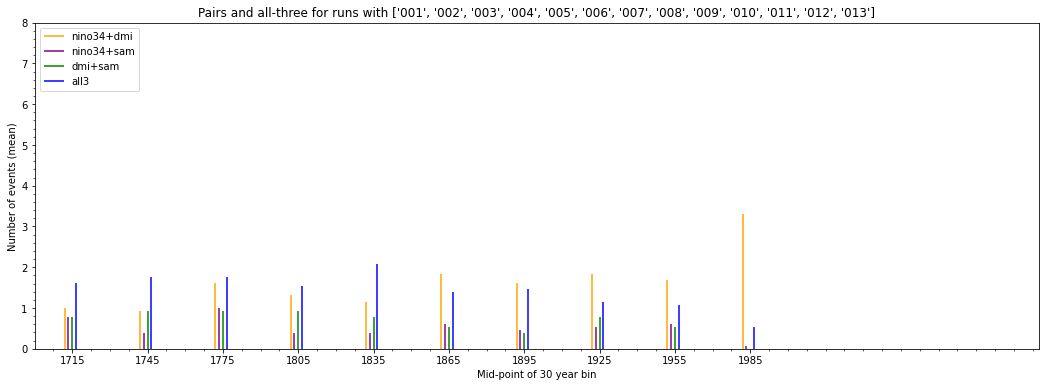

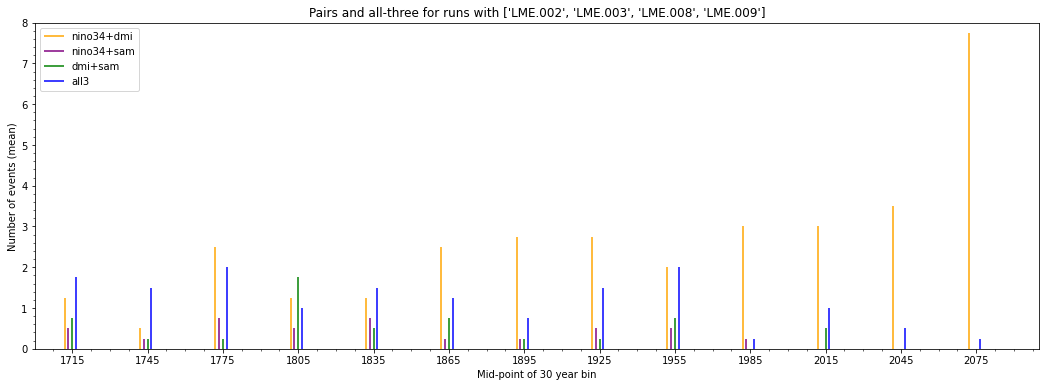

In [29]:
binPlot(binnedFirePos.where(binnedFirePos.year<=1985, drop=True), _model.cesmFullForcings)

binPlot(binnedFirePos, _model.cesmRcp85)

Group into three time periods: pre 1850, 1850-2005 and 2005 to 2100

In [30]:
groupA = binnedFirePos.sel(experiment=_model.cesmNoRepeats, year=slice(850,1850))
groupB = binnedFirePos.sel(experiment=_model.cesmNoRepeats, year=slice(1850,2006))
groupC = binnedFirePos.sel(experiment=_model.cesmNoRepeats, year=slice(2006,2100))

In [31]:
groupC.nino34.values.flatten()

array([ 5.,  3.,  6.,  5., nan, nan, nan, nan, nan, nan, nan, nan, nan,
        7.,  5.,  6.,  7., nan, nan, nan, nan, nan, nan, nan, nan, nan,
        7., 11., 10.,  8., nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [32]:
for iInd in toPlot:
    print(iInd)
    print(
        scipy.stats.f_oneway(
        groupA[iInd].values.flatten() , 
        groupB[iInd].values.flatten(), 
        groupC[iInd].values.flatten()
        )
    )

nino34+dmi
F_onewayResult(statistic=nan, pvalue=nan)
nino34+sam
F_onewayResult(statistic=nan, pvalue=nan)
dmi+sam
F_onewayResult(statistic=nan, pvalue=nan)
all3
F_onewayResult(statistic=nan, pvalue=nan)


In [33]:
for iInd in toPlot:
    print(iInd)
    print(
        scipy.stats.ttest_ind(groupA[iInd].values.flatten() , 
        groupB[iInd].values.flatten())
    )
    

nino34+dmi
Ttest_indResult(statistic=-4.4526780215668795, pvalue=1.0503432709625514e-05)
nino34+sam
Ttest_indResult(statistic=1.6404297310381832, pvalue=0.10155497189791542)
dmi+sam
Ttest_indResult(statistic=2.90410928047, pvalue=0.0038486082556662368)
all3
Ttest_indResult(statistic=3.6173225295063376, pvalue=0.0003284142289977348)


In [34]:
for iInd in toPlot:
    print(iInd)
    print(
        scipy.stats.ttest_ind(groupA[iInd].values.flatten() , 
        groupC[iInd].values.flatten())
    )
    

nino34+dmi
Ttest_indResult(statistic=nan, pvalue=nan)
nino34+sam
Ttest_indResult(statistic=nan, pvalue=nan)
dmi+sam
Ttest_indResult(statistic=nan, pvalue=nan)
all3
Ttest_indResult(statistic=nan, pvalue=nan)


In [35]:
def mySlowFunction(input):
    y=input[0]
    if y<1850:
        result='A'
    elif y<2006:
        result='B'
    else:
        result='C'
        
    return result

<AxesSubplot:title={'center':'nino34'}, xlabel='[<function mySlowFunction at 0x0000026BF201BF70>]'>

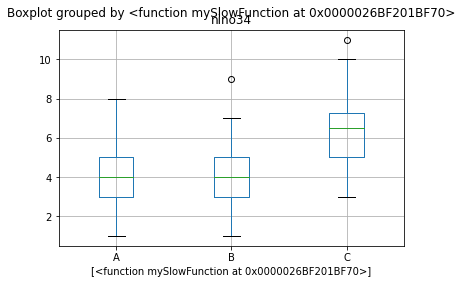

In [36]:
binnedFirePos.sel(experiment=_model.cesmNoRepeats).nino34.to_dataframe().boxplot(by=mySlowFunction)


# In overlapping 30 year bins

In [37]:
%run "utils/compound.ipynb"

overBinFirePos = overlappingBinSum(firePos)

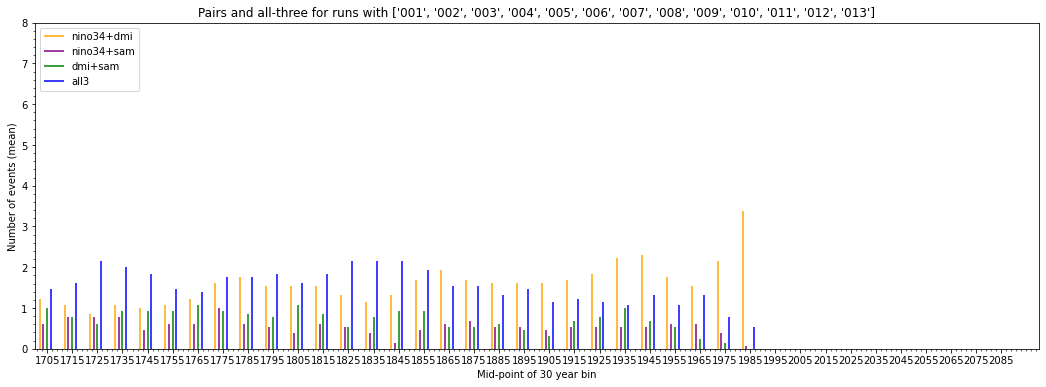

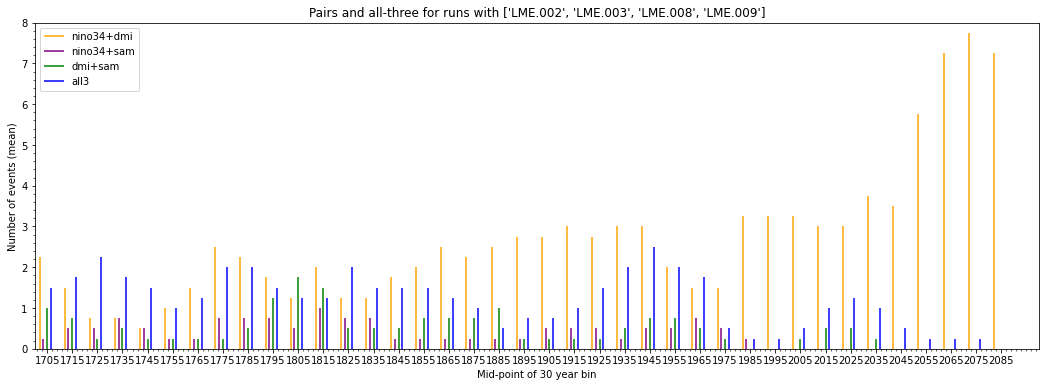

In [38]:
binPlot(overBinFirePos, _model.cesmFullForcings)

binPlot(overBinFirePos, _model.cesmRcp85)